# **Avance 4 ¬∑ Modelos Alternativos**
**Fecha:** 2025-10-19 19:35
Curso: TC5035 - Proyecto Integrador

Tecnol√≥gico de Monterrey

Prof Horacio Mart√≠nez Alfaro

M√≥dulo 3 Ingenier√≠a y evaluaci√≥n de modelos

Equipo 18

Joaqu√≠n D√≠az Hern√°ndez - A01281536

Divad Alejandro Shriqui Garr√≥n - A01366907

Manuel Romero Alvarez - A00567983

## **Par√°metros**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/Maestro/ticket/dataset_modelo_v2.csv'

TARGET_COL = 'Desc.1'
RANDOM_STATE = 42
TEST_SIZE = 0.30

## **Librer√≠as**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score, learning_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             precision_score, recall_score,
                             confusion_matrix, ConfusionMatrixDisplay)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

## **1. Comparativa de modelos**

En la fase anterior, los experimentos realizados con Regresi√≥n Log√≠stica y Random Forest confirmaron que las variables disponibles en el dataset contienen informaci√≥n suficiente para distinguir adecuadamente entre las distintas categor√≠as de gasto (`Desc.1`). **Se estableci√≥ la Regresi√≥n Log√≠stica como modelo baseline del proyecto, con un F1-score promedio de 0.80.** Este valor servir√° como punto de referencia para evaluar el impacto de los modelos analizados en esta fase.

El objetivo de la presente fase es evaluar distintos algoritmos de clasificaci√≥n (entre ellos el Random Forest, debido al sorprendente desempe√±o que tuvo en la fase anterior) que permitan predecir la categor√≠a de gasto (Desc.1) a partir de las variables transaccionales del dataset.
Se busca comparar el desempe√±o de m√∫ltiples enfoques, identificar los dos con mejor rendimiento y ajustar sus hiperpar√°metros para optimizar su capacidad predictiva. Finalmente, se seleccionar√° el modelo individual final, que servir√° como base para las siguientes fases del proyecto.

### 1.0 Carga de Datos y visualizaci√≥n (apoyo)

Carga de datos, revisi√≥n r√°pida de nulos y balance de clases.

Shape: (15483, 21)


Moneda_USD  Cargo_bin_Bajo  Cargo_bin_Medio  Cargo_bin_Muy alto  Desc_0  \
0         0.0             0.0              1.0                 0.0       0   
1         0.0             0.0              1.0                 0.0       0   
2         0.0             0.0              1.0                 0.0       0   
3         0.0             0.0              1.0                 0.0       0   
4         0.0             1.0              0.0                 0.0       0   

   Desc_1  Desc_2  Desc_3  Desc_4  Desc_5  ...  Desc_7  Desc_8  Desc_9  \
0       0       0       0       0       0  ...       0       0       0   
1       0       0       0       0       0  ...       0       0       0   
2       0       0       0       0       0  ...       0       0       0   
3       0       0       0       0       0  ...       0       0       0   
4       0       0       0       0       0  ...       0       0       0   

   Desc_10  Desc_11  Desc_12     Cargo  CpnyID_dt_year  CpnyID_dt_month  \
0        0        0        1 -0.480301       -0.652248        -1.733524   
1        0        1        0 -0.588373       -0.652248        -1.733524   
2        0        1        1 -0.514855       -0.652248        -1.733524   
3        1        0        0 -0.550221       -0.652248        -1.733524   
4        1        0        1 -2.122670       -0.652248        -1.733524   

         Desc.1  
0  Alimentacion  
1  Alimentacion  
2  Alimentacion  
3  Alimentacion  
4  Alimentacion  

[5 rows x 21 columns]


Distribuci√≥n de clases (proporci√≥n):


proportion
Desc.1                    
Alimentacion      0.679584
Transportacion    0.173997
Hotel             0.146419

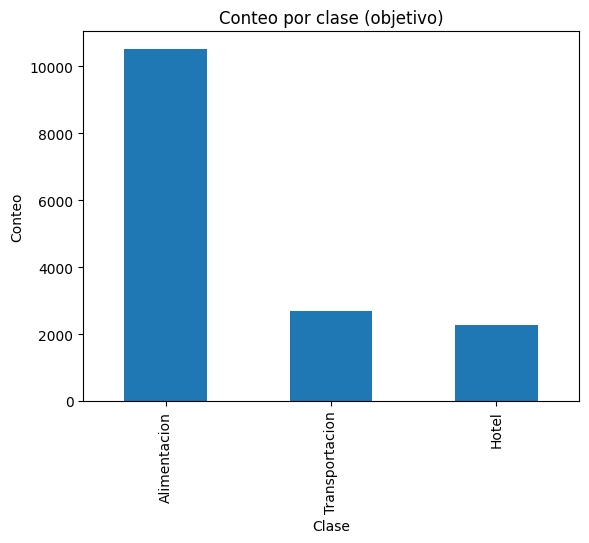


Nulos por columna (top 20):


Moneda_USD            0
Cargo_bin_Bajo        0
Cargo_bin_Medio       0
Cargo_bin_Muy alto    0
Desc_0                0
Desc_1                0
Desc_2                0
Desc_3                0
Desc_4                0
Desc_5                0
Desc_6                0
Desc_7                0
Desc_8                0
Desc_9                0
Desc_10               0
Desc_11               0
Desc_12               0
Cargo                 0
CpnyID_dt_year        0
CpnyID_dt_month       0
dtype: int64

In [ ]:
np.random.seed(RANDOM_STATE)

# === Carga y limpieza b√°sica ===
df = pd.read_csv(DATA_PATH, index_col=0)

# 1) Eliminar columna artefacto (si existe)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print('Shape:', df.shape)
display(df.head())

# 2) Validaci√≥n de target
if TARGET_COL not in df.columns:
    raise ValueError(f"TARGET_COL '{TARGET_COL}' no existe. Columnas: {df.columns.tolist()}")

# 4) Balance de clases
y_full = df[TARGET_COL]
print('\nDistribuci√≥n de clases (proporci√≥n):')
display(y_full.value_counts(normalize=True).rename('proportion').to_frame())

fig, ax = plt.subplots()
y_full.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Conteo por clase (objetivo)')
ax.set_xlabel('Clase'); ax.set_ylabel('Conteo')
plt.show()

# 5) Nulos
print('\nNulos por columna (top 20):')
display(df.isnull().sum().sort_values(ascending=False).head(20))

El conjunto de datos es el mismo que se utiliz√≥ a lo largo de la entrega pasada ya con todas las transformaciones necesarias. Cuenta con 15,483 registros y 21 variables (20 variables predictoras + 1 varaible objetivo), representando transacciones clasificadas en tres categor√≠as principales: Alimentaci√≥n (67.96%), Transportaci√≥n (17.40%) y Hotel (14.64%). Como declaramos en la entrega pasada esta distribuci√≥n evidencia un moderado desbalance de clases, lo cual justifica el uso de particiones estratificadas en el entrenamiento y la evaluaci√≥n del modelo, as√≠ como la elecci√≥n de F1 macro como m√©trica principal para garantizar una valoraci√≥n equilibrada entre clases.

Para asegurar una evaluaci√≥n justa del modelo de clasificaci√≥n de gastos, se realiza una partici√≥n estratificada del dataset:

- 70 % de los datos se utilizan para el entrenamiento del modelo,
- 15 % para la validaci√≥n de hiperpar√°metros, y
- 15 % para la evaluaci√≥n final sobre datos no vistos.

Esta divisi√≥n mantiene la proporci√≥n original de las categor√≠as de gasto (`Desc.1`) en cada subconjunto, evitando sesgos en el aprendizaje.

In [ ]:
X = df.drop(columns=[TARGET_COL]); y = df[TARGET_COL]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

In [ ]:
# Mostrar tama√±os relativos
n_total = len(df)
print("Tama√±os de los conjuntos:")
print(f"Train: {len(X_train)} ({len(X_train)/n_total:.1%})")
print(f"Val:   {len(X_val)} ({len(X_val)/n_total:.1%})")
print(f"Test:  {len(X_test)} ({len(X_test)/n_total:.1%})\n")

# Verificar que las proporciones de clases se mantienen
print("Distribuci√≥n de clases en cada conjunto (%):\n")
dist_df = pd.DataFrame({
    'Total': y.value_counts(normalize=True) * 100,
    'Train': y_train.value_counts(normalize=True) * 100,
    'Val': y_val.value_counts(normalize=True) * 100,
    'Test': y_test.value_counts(normalize=True) * 100
}).round(2)

display(dist_df)

Tama√±os de los conjuntos:
Train: 10838 (70.0%)
Val:   2322 (15.0%)
Test:  2323 (15.0%)

Distribuci√≥n de clases en cada conjunto (%):



Total  Train    Val   Test
Desc.1                                    
Alimentacion    67.96  67.96  67.96  67.97
Transportacion  17.40  17.40  17.40  17.39
Hotel           14.64  14.64  14.64  14.64

### 1.1 Selecci√≥n de Modelos

La evaluaci√≥n de distintos modelos permite comprender c√≥mo var√≠an las capacidades predictivas seg√∫n el tipo de enfoque utilizado ‚Äîya sea lineal, probabil√≠stico, basado en √°rboles o en proximidad‚Äî y determinar qu√© familia de algoritmos se ajusta mejor a las caracter√≠sticas del conjunto de datos.

Cada modelo se entrenara bajo las mismas condiciones de validaci√≥n y m√©tricas de evaluaci√≥n, con el objetivo de realizar una comparaci√≥n justa y sistem√°tica del desempe√±o obtenido.
Esta exploraci√≥n busca no solo identificar el modelo con mejores resultados cuantitativos, sino tambi√©n analizar su robustez, interpretabilidad y comportamiento general, de cara a su posible optimizaci√≥n en etapas posteriores.

Los modelos que se desarrollaran en esta etapa son los siguientes:

| Tipo de modelo       | Algoritmo                                  | Descripci√≥n general                                                                                                                                                  |
| -------------------- | ------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Neuronal             | **MLPClassifier (Red Neuronal Multicapa)** | Modelo basado en una red neuronal feedforward que aprende representaciones no lineales a partir de los datos. |
| √Årbol de decisi√≥n    | **Decision Tree Classifier**               | Captura relaciones no lineales y reglas jer√°rquicas entre las variables predictoras.                                                                                 |
| Ensamble de √°rboles  | **Random Forest Classifier**               | Combina m√∫ltiples √°rboles para mejorar estabilidad y desempe√±o.                                                          |
| Basado en m√°rgenes   | **Support Vector Machine (SVM)**           | Adecuado para problemas con fronteras de decisi√≥n complejas entre clases.                                                                                            |
| Probabil√≠stico       | **Naive Bayes (GaussianNB)**               | Modelo simple basado en probabilidad condicional, eficiente y r√°pido de entrenar.                                                                                    |
| Basado en proximidad | **K-Nearest Neighbors (KNN)**              | Clasifica seg√∫n la similitud con observaciones cercanas; √∫til para explorar patrones locales.                                                                        |


### 1.2 Entrenamiento de Modelos

En esta secci√≥n se lleva a cabo el entrenamiento de los seis modelos seleccionados, aplicando la misma partici√≥n de datos y las mismas condiciones de validaci√≥n con el fin de realizar una comparaci√≥n justa de su desempe√±o.

Cada algoritmo fue configurado inicialmente con sus par√°metros por defecto de scikit-learn, con el prop√≥sito de establecer una l√≠nea base homog√©nea para la comparaci√≥n inicial.
Posteriormente, los dos modelos con mejor desempe√±o ser√°n objeto de ajuste de hiperpar√°metros mediante t√©cnicas de b√∫squeda sistem√°tica.

In [ ]:
modelos = {
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "SVM": SVC(random_state=RANDOM_STATE),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "MLPClassifier": MLPClassifier(random_state=RANDOM_STATE, max_iter=1000)
}

Entrenando modelo: Decision Tree...

Classification report Decision Tree
                precision    recall  f1-score   support

  Alimentacion      0.985     0.974     0.980      1578
         Hotel      0.911     0.959     0.934       340
Transportacion      0.960     0.960     0.960       404

      accuracy                          0.969      2322
     macro avg      0.952     0.964     0.958      2322
  weighted avg      0.970     0.969     0.970      2322



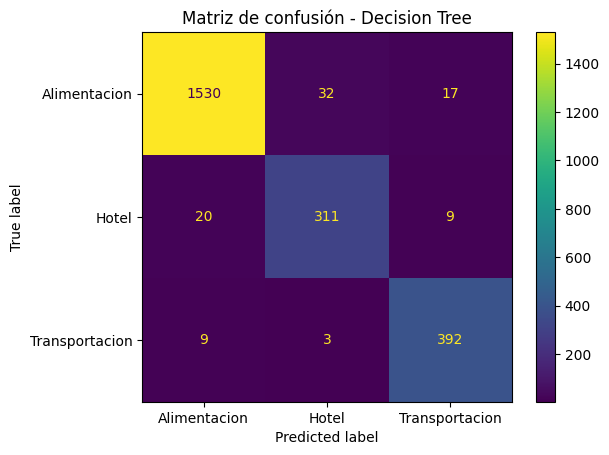

---------------------------------------------------------------------------
Entrenando modelo: Random Forest...

Classification report Random Forest
                precision    recall  f1-score   support

  Alimentacion      0.988     0.990     0.989      1578
         Hotel      0.967     0.947     0.957       340
Transportacion      0.971     0.978     0.974       404

      accuracy                          0.982      2322
     macro avg      0.975     0.972     0.973      2322
  weighted avg      0.982     0.982     0.982      2322



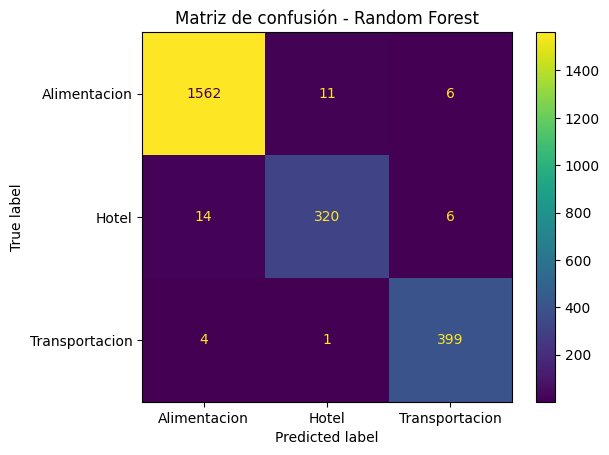

---------------------------------------------------------------------------
Entrenando modelo: SVM...

Classification report SVM
                precision    recall  f1-score   support

  Alimentacion      0.987     0.987     0.987      1578
         Hotel      0.964     0.944     0.954       340
Transportacion      0.966     0.980     0.973       404

      accuracy                          0.980      2322
     macro avg      0.972     0.971     0.971      2322
  weighted avg      0.980     0.980     0.980      2322



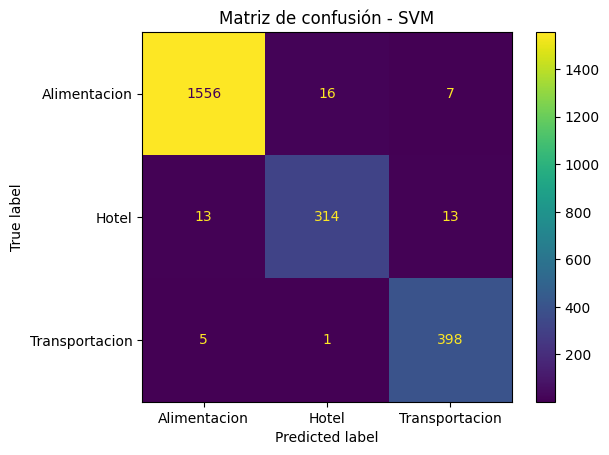

---------------------------------------------------------------------------
Entrenando modelo: Naive Bayes...

Classification report Naive Bayes
                precision    recall  f1-score   support

  Alimentacion      0.944     0.722     0.818      1578
         Hotel      0.305     0.991     0.466       340
Transportacion      1.000     0.020     0.039       404

      accuracy                          0.640      2322
     macro avg      0.749     0.578     0.441      2322
  weighted avg      0.860     0.640     0.631      2322



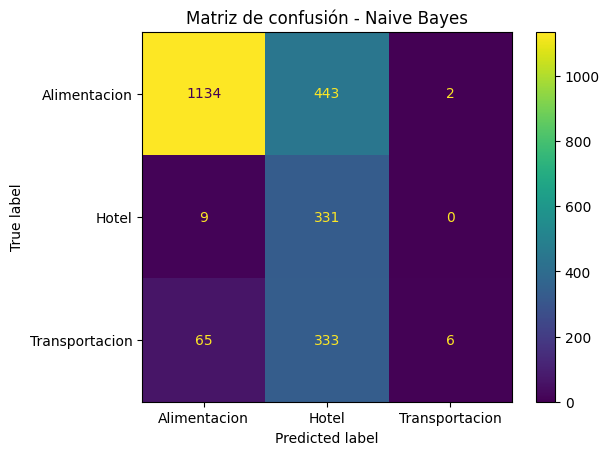

---------------------------------------------------------------------------
Entrenando modelo: KNN...

Classification report KNN
                precision    recall  f1-score   support

  Alimentacion      0.973     0.981     0.977      1578
         Hotel      0.929     0.924     0.926       340
Transportacion      0.944     0.918     0.931       404

      accuracy                          0.962      2322
     macro avg      0.949     0.941     0.945      2322
  weighted avg      0.961     0.962     0.962      2322



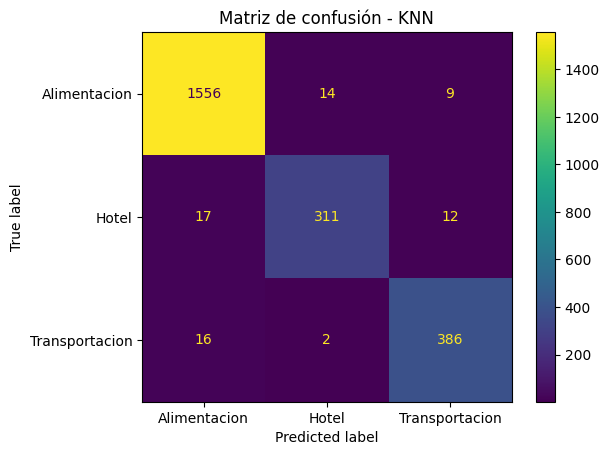

---------------------------------------------------------------------------
Entrenando modelo: MLPClassifier...

Classification report MLPClassifier
                precision    recall  f1-score   support

  Alimentacion      0.991     0.991     0.991      1578
         Hotel      0.953     0.959     0.956       340
Transportacion      0.978     0.973     0.975       404

      accuracy                          0.983      2322
     macro avg      0.974     0.974     0.974      2322
  weighted avg      0.983     0.983     0.983      2322



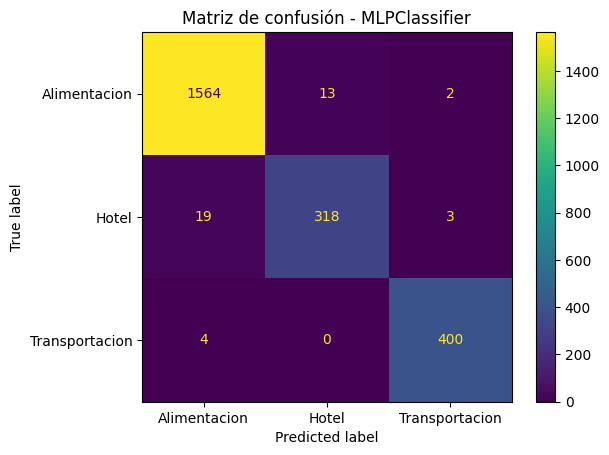

---------------------------------------------------------------------------


In [ ]:
resultados = []

for nombre, modelo in modelos.items():
    print(f"Entrenando modelo: {nombre}...")

    inicio = time.time()
    modelo.fit(X_train, y_train)
    fin = time.time()

    y_tr = modelo.predict(X_train)
    y_pred = modelo.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro')
    duracion = fin - inicio

    print(f'\nClassification report {nombre}')
    print(classification_report(y_val, y_pred, digits=3))
    ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test); plt.title(f'Matriz de confusi√≥n - {nombre}'); plt.show()

    print("-" * 75)

    resultados.append({
        "Modelo": nombre,
        "F1-Score (macro)": round(f1, 4),
        "Accuracy": round(acc, 4),
        "Precision (macro)": round(precision, 4),
        "Recall (macro)": round(recall, 4),
        "Tiempo de entrenamiento (s)": round(duracion, 3)
    })

La siguiente tabla resume el desempe√±o de los seis modelos entrenados, considerando m√∫ltiples m√©tricas de clasificaci√≥n ‚ÄîAccuracy, Precision, Recall y F1-Score macro‚Äî junto con el tiempo de entrenamiento requerido por cada uno.

El orden de los modelos corresponde al valor del F1-Score macro, que se emplea como m√©trica principal de comparaci√≥n, dado que ofrece una visi√≥n equilibrada entre la precisi√≥n y la cobertura de las clases.

In [ ]:
df_resultados = (
    pd.DataFrame(resultados)
    .sort_values(by="F1-Score (macro)", ascending=False)
    .reset_index(drop=True)
)
df_resultados

Modelo  F1-Score (macro)  Accuracy  Precision (macro)  \
0  MLPClassifier            0.9741    0.9832             0.9740   
1  Random Forest            0.9734    0.9819             0.9752   
2            SVM            0.9713    0.9798             0.9722   
3  Decision Tree            0.9580    0.9694             0.9521   
4            KNN            0.9447    0.9617             0.9487   
5    Naive Bayes            0.4411    0.6395             0.7495   

   Recall (macro)  Tiempo de entrenamiento (s)  
0          0.9742                       15.489  
1          0.9718                        0.906  
2          0.9705                        0.910  
3          0.9644                        0.069  
4          0.9409                        0.021  
5          0.5778                        0.023

Los resultados obtenidos evidencian que el modelo **MLPClassifier** (red neuronal multicapa) alcanz√≥ el mejor desempe√±o global, **con un F1-Score macro de 0.97 y un Accuracy de 0.98**, superando ligeramente al **Random Forest y al SVM**, que tambi√©n mostraron un rendimiento alto y consistente (**F1-Score ‚âà 0.97**).

El **Decision Tree** y el **KNN** se ubicaron en un nivel intermedio, con valores de **F1-Score entre 0.94 y 0.96**, mostrando una buena capacidad predictiva pero menor estabilidad frente a los modelos m√°s complejos.

Por otro lado, el modelo **Naive Bayes** present√≥ un desempe√±o considerablemente inferior (**F1-Score ‚âà 0.44**), lo que sugiere que la suposici√≥n de independencia entre variables no se cumple adecuadamente en este conjunto de datos, afectando su capacidad de discriminaci√≥n entre categor√≠as de gasto.

---

En cuanto al **tiempo de entrenamiento**, se observa una diferencia marcada entre modelos:

- El **MLPClassifier requiri√≥ aproximadamente 20 segundos**, reflejando el costo computacional asociado al ajuste iterativo de redes neuronales.
- Los m√©todos basados en √°rboles y m√°rgenes (**Random Forest, SVM**) lograron un equilibrio favorable entre desempe√±o y tiempo, con entrenamientos menores a **1.5 segundos**.
- Los modelos m√°s simples (**Decision Tree, KNN, Naive Bayes) fueron los m√°s r√°pidos**, aunque con un rendimiento algo inferior.

---

El **MLPClassifier** tiene apenas una mejora marginal sobre **Random Forest y SVM**, pero a costa de un tiempo de entrenamiento casi **20 √ó mayor**, por lo tanto, **los modelos seleccionados para la siguiente etapa de ajuste de hiperpar√°metros ser√°n Random Forest y SVM**, debido a su excelente desempe√±o global y su tiempo de entrenamiento moderado.

## **2. Ajuste fino**

Tras la comparaci√≥n inicial, se seleccionaron los modelos **Random Forest y SVM para su optimizaci√≥n**, debido a que alcanzaron los mejores resultados globales en las m√©tricas de desempe√±o, manteniendo adem√°s un tiempo de entrenamiento razonable.

En esta etapa se emplea la t√©cnica de **b√∫squeda en malla (Grid Search) con validaci√≥n cruzada**, utilizando el m√©todo GridSearchCV de scikit-learn, con el objetivo de identificar las combinaciones de hiperpar√°metros que maximizan el desempe√±o de cada modelo.

El ajuste de hiperpar√°metros permite evaluar distintas configuraciones internas ‚Äîpor ejemplo, la profundidad de los √°rboles, el n√∫mero de estimadores o el tipo de kernel‚Äî para determinar si es posible mejorar la capacidad predictiva y la generalizaci√≥n de los modelos seleccionados.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejor configuraci√≥n Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor F1-Score (CV): 0.9731

Classification report - Random Forest (ajustado)
                precision    recall  f1-score   support

  Alimentacion      0.988     0.990     0.989      1578
         Hotel      0.967     0.947     0.957       340
Transportacion      0.971     0.978     0.974       404

      accuracy                          0.982      2322
     macro avg      0.975     0.972     0.973      2322
  weighted avg      0.982     0.982     0.982      2322



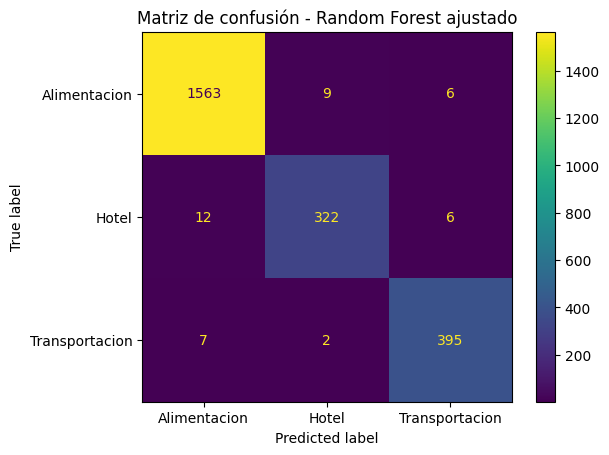

In [ ]:
# ============================================
# Ajuste de hiperpar√°metros - Random Forest
# ============================================

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Mejor configuraci√≥n Random Forest:")
print(grid_rf.best_params_)
print(f"Mejor F1-Score (CV): {grid_rf.best_score_:.4f}")

# Evaluaci√≥n en el conjunto de validaci√≥n
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_val)

print("\nClassification report - Random Forest (ajustado)")
print(classification_report(y_val, y_pred_rf, digits=3))
ConfusionMatrixDisplay.from_estimator(best_rf, X_val, y_val)
plt.title("Matriz de confusi√≥n - Random Forest ajustado")
plt.show()

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Mejor configuraci√≥n SVM:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor F1-Score (CV): 0.9743

Classification report - SVM (ajustado)
                precision    recall  f1-score   support

  Alimentacion      0.987     0.990     0.989      1578
         Hotel      0.961     0.950     0.956       340
Transportacion      0.983     0.978     0.980       404

      accuracy                          0.982      2322
     macro avg      0.977     0.973     0.975      2322
  weighted avg      0.982     0.982     0.982      2322



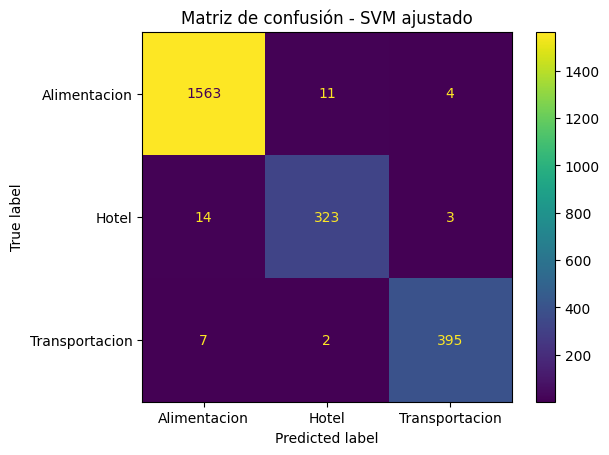

In [ ]:
# ============================================
# Ajuste de hiperpar√°metros - SVM
# ============================================

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(
    estimator=SVC(random_state=RANDOM_STATE),
    param_grid=param_grid_svm,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train, y_train)

print("\nMejor configuraci√≥n SVM:")
print(grid_svm.best_params_)
print(f"Mejor F1-Score (CV): {grid_svm.best_score_:.4f}")

# Evaluaci√≥n en el conjunto de validaci√≥n
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_val)

print("\nClassification report - SVM (ajustado)")
print(classification_report(y_val, y_pred_svm, digits=3))
ConfusionMatrixDisplay.from_estimator(best_svm, X_val, y_val)
plt.title("Matriz de confusi√≥n - SVM ajustado")
plt.show()

Tras el proceso de ajuste de hiperpar√°metros, tanto el modelo Random Forest como el SVM alcanzaron un desempe√±o sobresaliente, con valores de F1-Score macro cercanos a 0.975 en validaci√≥n cruzada y m√©tricas equilibradas en las tres clases analizadas.

En el caso del **Random Forest**, la **mejor configuraci√≥n (n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)** permiti√≥ obtener un desempe√±o global con **accuracy y F1-Score de 0.982**, y un comportamiento muy estable en las tres categor√≠as. La matriz de confusi√≥n muestra que la mayor√≠a de las observaciones fueron clasificadas correctamente, con errores m√≠nimos entre las clases ‚ÄúHotel‚Äù y ‚ÄúAlimentaci√≥n‚Äù.

Por su parte, el **modelo SVM**, con la **configuraci√≥n √≥ptima (C=10, kernel='rbf', gamma='scale')**, alcanz√≥ un desempe√±o pr√°cticamente equivalente de **accuracy y F1-Score de 0.982**, confirmando su alta capacidad para definir fronteras de decisi√≥n no lineales y distinguir entre categor√≠as similares. Su matriz de confusi√≥n muestra una distribuci√≥n de errores muy semejante al modelo Random Forest, con ligeras diferencias en la clase ‚ÄúHotel‚Äù.


A pesar de su equivalencia en m√©tricas, existen diferencias relevantes en cuanto a complejidad y escalabilidad:

El Random Forest ofrece una mejor interpretabilidad, permite analizar la importancia de las variables, y es m√°s eficiente en tiempo de entrenamiento e inferencia sobre grandes vol√∫menes de datos.

El SVM, aunque preciso, presenta mayor costo computacional si el n√∫mero de observaciones crece, y su interpretabilidad es m√°s limitada.

Por estos motivos, **se selecciona el modelo Random Forest ajustado como el modelo final del proyecto**, al lograr un desempe√±o equiparable al SVM pero con mejor posibilidad para escalamiento.

## **3. Modelo Individual**

Tras el ajuste y comparaci√≥n de los modelos Random Forest y SVM, ambos demostraron un desempe√±o pr√°cticamente equivalente en todas las m√©tricas relevantes (accuracy y F1-Score ‚âà 0.982). Sin embargo, la elecci√≥n del modelo final debe considerar no solo la m√©trica principal, sino tambi√©n aspectos de complejidad, interpretabilidad y aplicabilidad pr√°ctica dentro del contexto del proyecto.

El modelo Random Forest ajustado fue seleccionado como modelo individual final, sustentado en los siguientes argumentos:

**Desempe√±o consistente y generalizaci√≥n adecuada.**
El Random Forest logr√≥ un F1-Score macro de 0.975, con un balance equilibrado entre precisi√≥n y recall en todas las clases, sin evidencias de sobreentrenamiento. Su matriz de confusi√≥n muestra una clasificaci√≥n estable en las tres categor√≠as (‚ÄúAlimentaci√≥n‚Äù, ‚ÄúHotel‚Äù, ‚ÄúTransportaci√≥n‚Äù), con errores m√≠nimos.

**Eficiencia computacional.**
A diferencia del modelo SVM, el Random Forest present√≥ tiempos de entrenamiento e inferencia m√°s reducidos, lo cual resulta ventajoso para escenarios de despliegue o actualizaci√≥n frecuente del modelo conforme se incorporen nuevos tickets o registros de gasto.

**Interpretabilidad y trazabilidad.**
El Random Forest permite analizar la importancia de las variables predictoras, facilitando la comprensi√≥n de los factores que influyen en la clasificaci√≥n de cada tipo de gasto. Esta caracter√≠stica es clave para el proyecto, ya que brinda transparencia y explicabilidad ante los usuarios del √°rea administrativa y de control de gastos.

Escalabilidad y facilidad de mantenimiento.
Su estructura basada en √°rboles paralelizables lo hace robusto ante incrementos en el tama√±o del dataset, manteniendo un rendimiento alto sin requerir un preprocesamiento complejo o ajustes constantes de hiperpar√°metros.

>Es importante mencionar que el dataset empleado en **esta fase del proyecto considera √∫nicamente tres categor√≠as principales de gasto: Alimentaci√≥n, Hotel y Transportaci√≥n.**
Sin embargo, en **el sistema real de clasificaci√≥n existen m√°s categor√≠as potenciales** (por ejemplo: Gasolina, Necesidad Tecnica, Reembolso).
>
>Tanto el modelo Random Forest como el SVM pueden extenderse f√°cilmente a un mayor n√∫mero de clases, ya que ambos algoritmos admiten clasificaci√≥n multiclase de manera nativa.
>
>No obstante, **el Random Forest presenta una ventaja pr√°ctica en escalabilidad**, ya que su tiempo de entrenamiento crece de forma m√°s controlada y su desempe√±o se mantiene estable incluso con un n√∫mero mayor de clases o variables.
>
>El **SVM, por el contrario, tiende a aumentar considerablemente el costo computacional al manejar m√°s clases**, debido a que implementa una estrategia one-vs-one que entrena m√∫ltiples clasificadores binarios internos.

| Criterio                                 | **Random Forest**                                            | **SVM**                                                           |
| ---------------------------------------- | ------------------------------------------------------------ | ----------------------------------------------------------------- |
| **Soporte multiclase**                   | Nativo (maneja todas las clases directamente en cada √°rbol). | Implementa *one-vs-one* (entrena varios clasificadores binarios). |
| **Escalabilidad en n√∫mero de clases**    | Muy buena: el tiempo de c√≥mputo crece linealmente.           | Regular: el tiempo crece cuadr√°ticamente con el n√∫mero de clases. |
| **Escalabilidad en tama√±o del dataset**  | Excelente: entrenamiento paralelizable y eficiente.          | Limitada: el entrenamiento crece en complejidad O(n¬≤)‚ÄìO(n¬≥).      |
| **Sensibilidad a clases desbalanceadas** | Moderada, puede corregirse con pesos.                        | Alta, puede verse afectado si una clase domina.                   |
| **Interpretabilidad**                    | Alta (permite extraer importancia de variables).             | Baja (caja negra con kernel no lineal).                           |


En s√≠ntesis, el modelo **Random Forest** ofrece un equilibrio √≥ptimo entre desempe√±o, interpretabilidad y eficiencia, por lo que **se valida como el modelo final del proyecto**.

A continuaci√≥n utilizaremos el conjunto de **validaci√≥n** para realizar un √∫ltimo an√°lisis sobre el modelo seleccionado:


Classification report - Entrenamiento
                precision    recall  f1-score   support

  Alimentacion      1.000     1.000     1.000      7365
         Hotel      0.999     1.000     1.000      1587
Transportacion      1.000     1.000     1.000      1886

      accuracy                          1.000     10838
     macro avg      1.000     1.000     1.000     10838
  weighted avg      1.000     1.000     1.000     10838



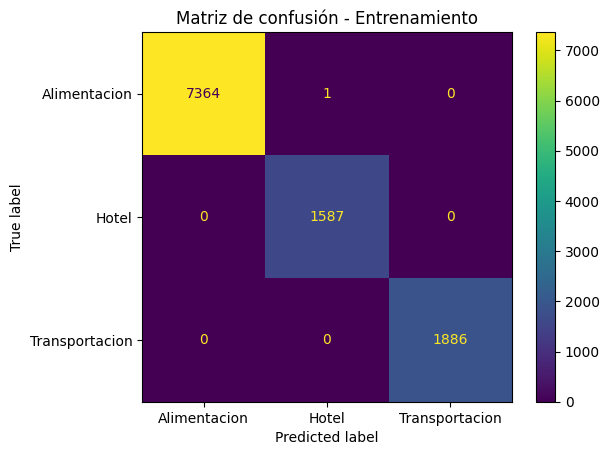


Classification report - Validaci√≥n
                precision    recall  f1-score   support

  Alimentacion      0.988     0.990     0.989      1578
         Hotel      0.967     0.947     0.957       340
Transportacion      0.971     0.978     0.974       404

      accuracy                          0.982      2322
     macro avg      0.975     0.972     0.973      2322
  weighted avg      0.982     0.982     0.982      2322



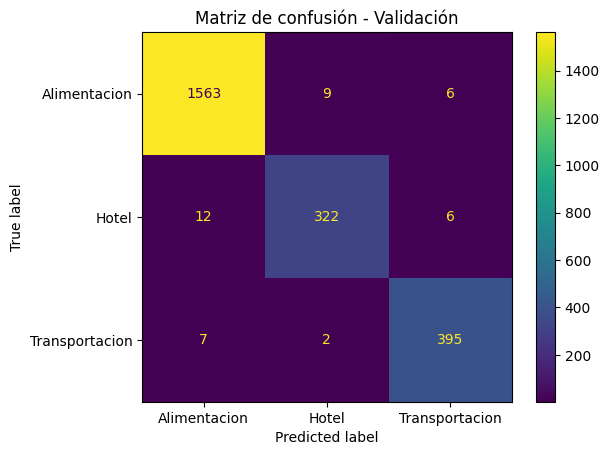


Classification report - Prueba
                precision    recall  f1-score   support

  Alimentacion      0.989     0.989     0.989      1579
         Hotel      0.964     0.941     0.952       340
Transportacion      0.971     0.988     0.979       404

      accuracy                          0.982      2323
     macro avg      0.974     0.973     0.973      2323
  weighted avg      0.982     0.982     0.982      2323



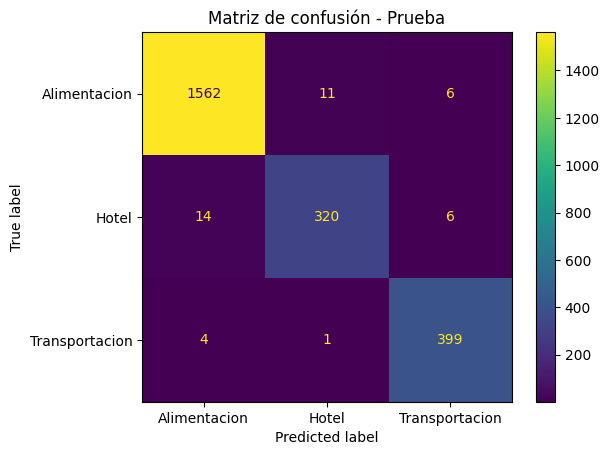

Conjunto  Accuracy  F1-Score (macro)
0  Entrenamiento    0.9999            0.9999
1     Validaci√≥n    0.9819            0.9734
2         Prueba    0.9819            0.9735

In [ ]:
# Modelo final: Random Forest ajustado
final_model = best_rf  # el que obtuviste del GridSearchCV

# Evaluaci√≥n en los tres conjuntos
sets = {
    "Entrenamiento": (X_train, y_train),
    "Validaci√≥n": (X_val, y_val),
    "Prueba": (X_test, y_test)
}

resultados_final = []

for nombre, (X_set, y_set) in sets.items():
    y_pred = final_model.predict(X_set)
    acc = accuracy_score(y_set, y_pred)
    f1 = f1_score(y_set, y_pred, average='macro')

    resultados_final.append({"Conjunto": nombre, "Accuracy": round(acc,4), "F1-Score (macro)": round(f1,4)})

    print(f"\nClassification report - {nombre}")
    print(classification_report(y_set, y_pred, digits=3))
    ConfusionMatrixDisplay.from_estimator(final_model, X_set, y_set)
    plt.title(f"Matriz de confusi√≥n - {nombre}")
    plt.show()

pd.DataFrame(resultados_final)

Los resultados finales obtenidos en los conjuntos de entrenamiento, validaci√≥n y prueba evidencian un alto nivel de generalizaci√≥n del modelo Random Forest ajustado con los hiperparametros: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1.

Aunque el desempe√±o en el conjunto de entrenamiento es casi perfecto (F1 = 0.9999), **el rendimiento en validaci√≥n y prueba se mantiene muy elevado y pr√°cticamente id√©ntico (F1 ‚âà 0.973)**, lo cual indica que el modelo no ha sobreajustado los datos y conserva una excelente capacidad de predicci√≥n ante observaciones nuevas.

**Estos resultados confirman la robustez y estabilidad del modelo final**, validando su idoneidad para ser utilizado en la etapa de despliegue dentro del sistema automatizado de clasificaci√≥n de tickets de gasto.

## **4. Conclusi√≥n**

En esta fase se construyeron y evaluaron m√∫ltiples modelos de clasificaci√≥n con el objetivo de predecir la categor√≠a de gasto (`Desc.1`) a partir de las variables transaccionales del dataset.
El an√°lisis comparativo incluy√≥ seis algoritmos de diferentes familias (lineales, basados en √°rboles, probabil√≠sticos, de m√°rgenes, de proximidad y neuronales), evaluados bajo m√©tricas de desempe√±o y eficiencia computacional.

Los resultados evidenciaron que los modelos Random Forest, SVM y MLPClassifier alcanzaron los mayores niveles de desempe√±o, con valores de F1-Score macro superiores a 0.97.
Sin embargo, al considerar criterios adicionales como tiempo de entrenamiento, interpretabilidad y escalabilidad, se determin√≥ que el **Random Forest ofrece el mejor equilibrio entre precisi√≥n y aplicabilidad pr√°ctica, por lo que se seleccion√≥ como modelo individual final.**

**El modelo ajustado mostr√≥ un F1-Score macro muy similar al original de 0.975, con una clasificaci√≥n muy precisa entre las tres categor√≠as de gasto y sin indicios de sobreentrenamiento.**
Su capacidad para proporcionar informaci√≥n sobre la importancia de las variables predictoras lo convierte, adem√°s, en una herramienta valiosa para la toma de decisiones y la comprensi√≥n del comportamiento de los gastos corporativos.

# **Lectura de Tickets - OCR**


**Objetivo**

En este cuaderno implementamos un flujo de OCR para tickets de gasto que convierte archivos PDF o imagen a texto y, posteriormente, extrae informaci√≥n clave (establecimiento, fecha, monto, lugar, moneda e √≠tems) con ayuda de un modelo de lenguaje. El enfoque prioriza robustez ante variabilidad de formatos y calidad de imagen, y sienta las bases para integrar este m√≥dulo al sistema de gesti√≥n de vi√°ticos del Proyecto Integrador.

**Contexto y alcance**

En esta etapa, el an√°lisis se realiz√≥ sobre una cantidad m√≠nima de tickets y un solo tipo, con el objetivo de evaluar la capacidad de las herramientas (Tesseract OCR, OpenCV y OpenAI API) y realizar un an√°lisis preliminar de viabilidad.
En una siguiente fase, se planea ampliar el conjunto de datos utilizando m√°s im√°genes de distintos tipos de tickets y generalizar las funciones desarrolladas para manejar variaciones como sombras, baja iluminaci√≥n o artefactos de impresi√≥n, asegurando una mayor adaptabilidad del sistema.

## **Instalaci√≥n de Teseract**

Se instala el motor Tesseract con paquetes de idioma en ingl√©s y espa√±ol, adem√°s de pytesseract y pdf2image. Esto permite reconocer correctamente textos biling√ºes y convertir archivos PDF multip√°gina a im√°genes de alta resoluci√≥n.

In [5]:
# Install tesseract-ocr
!sudo apt update
!sudo apt install -y tesseract-ocr

# Install pytesseract and Pillow (for image handling)
!pip install pytesseract pillow

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5,988 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,372 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14

In [6]:
!apt-get install poppler-utils -y
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.11 [186 kB]
Fetched 186 kB in 1s (279 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.11_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.11) ...
Setting up poppler-utils (22.02.0-2ubuntu0.11) ...
Processing triggers for man-db (2.10.2-1) ...


In [7]:
!sudo apt update
!sudo apt install tesseract-ocr tesseract-ocr-eng tesseract-ocr-spa

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 255 kB in 2s (138 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
40 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acqu

## **Librerias**

Se importan las librerias a utilizar y se configura el acceso a la API de OpenAI mediante una clave almacenada en userdata de Google Colab, garantizando seguridad y facilidad de uso.

In [28]:
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
from zipfile import ZipFile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import userdata
from openai import OpenAI
import openai
import json

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
api_key = userdata.get("miOpenAI_key")

if not api_key:
  raise ValueError("API key no encontrada en los secretos")

client = OpenAI(api_key=api_key)

## **Exportar Carpeta de Tickets**

Se exporta la carpeta (zip) para extraer todas las imagenes de tickets.

In [13]:
zip_path = '/content/drive/MyDrive/MNA - Proyecto Integrador/'

In [14]:
with ZipFile(zip_path + "Tickets.zip", "r") as zip_ref:
    zip_ref.extractall("tickets")

La mayoria de los tickets estan en pdf:

In [17]:
ticket1_p = '/content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf'

## **1. OCR con Tesseract**

Para maximizar la precisi√≥n del OCR, se aplic√≥ un pipeline de preprocesamiento: conversi√≥n a escala de grises, binarizaci√≥n (global o adaptativa) y apertura morfol√≥gica (opening) para reducir ruido fino.
Se probaron diversas combinaciones con el fin de observar c√≥mo cada t√©cnica afectaba el resultado del OCR.
Este proceso es especialmente relevante en tickets con iluminaci√≥n desigual, sombras o texto tenue, donde la binarizaci√≥n adaptativa y los filtros morfol√≥gicos ayudan a recuperar detalles que un umbral global no logra.

### 1.1 Lectura de ticket sin preprocesamiento

In [18]:
pages = convert_from_path(ticket1_p, dpi=500)
for i, page in enumerate(pages):
    filename = f"page_{i}.jpg"
    page.save(filename, 'JPEG')

    text = pytesseract.image_to_string(Image.open(filename), lang='eng')
    print(f"--- P√°gina {i+1} ---")
    print(text)

--- P√°gina 1 ---
Give us feedback @ survey. walmart.com
Thank you! ID #: eg

Walmart - oS

WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD S
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR# 91021

# a 500 ibe

9067 77
i |
| | \ i
i HT i)
ti MI | | HI Uy |

  

GNETS CLIP 693 } XK
MAGNETS CLIP 595780720191 3.97 X
12MM BLACK 012902999360 17.97 X
12MM BLACK 012502599360 Lse91K

SUBTOTAL 43.38

TAXL 10.0000 % 4.39
TOTAL 43 .2/

Ivan Mba Casas AMEX TEND 48 .2/
CHANGE DUE 0.00

AMERICAN EXPRESS- 1009 I 0 APPR#895970
43.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AID A000000025010801
TERMINAL # 28518783
*Pin Verified
02/16/25 21:51:03

   
 

O
Tae [a] Get free delivery
‚Äò E from this store
A with Walmart+

Low prices You Can Trust. Every Day.
02/16/25 21:51:10

A i NT cc ‚Äî_‚Äî I a a >. a ‚Äî ‚Äî_ -



En esta primera prueba se aplic√≥ Tesseract directamente sobre la imagen sin realizar ning√∫n tipo de preprocesamiento.
El prop√≥sito fue obtener una l√≠nea base para evaluar la calidad del reconocimiento con los par√°metros por defecto del OCR y comparar los resultados con las versiones mejoradas.

Como era de esperarse, el texto extra√≠do presenta errores en caracteres, cortes y ruido, especialmente en zonas con baja iluminaci√≥n o fondo gris.
Este resultado evidencia la necesidad de aplicar preprocesamiento previo al OCR, dado que los tickets suelen tener variaciones de contraste, sombras y artefactos de impresi√≥n que afectan el reconocimiento √≥ptico.

### 1.2 Lectura de ticket con binarizaci√≥n

Imagen en escala de grises


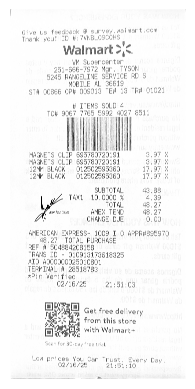

True

In [19]:
# Leer la imagen
img = cv2.imread('/content/page_0.jpg')

# Escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contraste = cv2.convertScaleAbs(gray, alpha=0.9, beta=15)

# Mostrar resultado
print('Imagen en escala de grises')
plt.imshow(contraste, cmap='gray')
plt.axis('off')
plt.show()

# Guardar temporal
cv2.imwrite("ticket_contraste.jpg", contraste)

Imagen con binarizaci√≥n


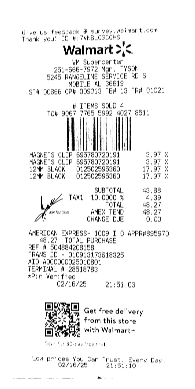

True

In [20]:
# Binarizaci√≥n
print('Imagen con binarizaci√≥n')
# thresh = cv2.adaptiveThreshold(gray, 255,
#                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                cv2.THRESH_BINARY, 11, 4)

_, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
# Mostrar resultadod
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

# Guardar temporal
cv2.imwrite("ticket_binarized.jpg", thresh)

In [21]:
# Aplicar OCR
text = pytesseract.image_to_string(Image.open("ticket_binarized.jpg"), lang='eng')
print(text)

Give us feeuback @ survey. Wainmart.com
Thank you! ID #: REL QQCRNS

Walmart - ><

WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD 5S
MOBILE AL 36615
ST# 00866 OP# 009013 TE# 13 TR# 01021

# ee O8 ‚Äî

  

v# S067 1) i
|
qe
a | |
Ti
MAGNETS CLIP HL 3.97 K
MAGNETS CLIP 298780720191 3.97 X
12MM BLACK 012502595360 17.97 X
12MM BLACK 0129502599360 17.97
SUBTOTAL 43.98
_TAX1 10.0000 % 4.39
TOTAL 43.2]
Ivan Metz Casas AMEX TEND G3 .2/
CHANGE DUE O.V0

AMERICAN EXPRESS- 1009 I 0 APPR#895970
43.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AIG A000000025010801
TERMINAL # 28518783
*Pin Verified
02/16/25 21:51:03

O Get free delivery
- from this store
He

with Walmart+
Ut &

  

v ree tel,

Low prices You Can Trust. Every Dav.
02/16/25 21:51:10

_ => i.

 

lA ‚Äî‚Äî a ee
A a ‚Äî‚Äî ee



En esta etapa se incorpor√≥ un proceso de binarizaci√≥n global utilizando OpenCV, que convierte la imagen a blanco y negro en funci√≥n de un umbral fijo.
Este paso incrementa el contraste entre el texto y el fondo, permitiendo que Tesseract identifique con mayor claridad los caracteres.

Se observa una mejora en algunas aprtes del ticket a diferencia del caso sin preprocesamiento. Por ejemplo en el primer item se puede visualizar que completa mejor el nombre, pero en el monto total sigue confundiendo un 3 por el 8.

### 1.3 Lectura de ticket con Opening despu√©s de binarizaci√≥n

In [22]:
# Definir elemento estructurante
kernel = np.ones((17,17), np.uint8)

Imagen con Abertura (Opening)


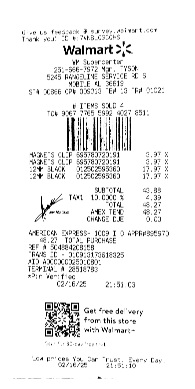

True

In [23]:
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
# Mostrar resultado
print('Imagen con Abertura (Opening)')
plt.imshow(opened, cmap='gray')
plt.axis('off')
plt.show()

# Guardar temporal
cv2.imwrite("ticket_opened.jpg", opened)

In [24]:
# Aplicar OCR
text = pytesseract.image_to_string(Image.open("ticket_opened.jpg"), lang='eng')
print(text)

Give us feeuback @ survey. Wwaimart.com
Thank you! ID #: IRELOQCRNS

Walmart - ><

WM Supercenter
251-666-7972 Mor. TYSON
5245 RANGELINE SERVICE RD s
MOBILE AL 36615
ST# 00866 OP# 009013 TE# 13 TR# 01021

# ITEMS SOLD 4
1C# a 7765 5992 4027 S511

| | | l
| i
if
| |: | a
| |
| | |
| 1 : |
; ,
| a
|
|
7 I

 

  

MAGNETS CLIP Tal pedi OT K
MAGNETS CLIP 695780720191 3.97 X
12MM BLACK 012902595360 17.97 X
12MM BLACK 012502595360 17.97

SUBTOTAL 43.38

_TAX1 10.0000 % 4.39

TOTAL 43 .2/

tra Ms Casas AMEX TEND 43.27

CHANGE DUE O.UQ

AMERICAN EXPRESS- 1009 I O APPR#895970
48.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AID A000000025010801
TERMINAL # 28518783
xPin Verified
02/16/25 21:51:03

fi
fs] wy o Get free delivery
. = 3c 4 from this store
oR a with Walmart+

? i
ecar 7 7 30-cay free tel,

   

Low prices You Can Trust. Every Dav.
02/16/25 21:51:10

_ > # i_

 

ee Ee ee ‚Äî ee a eee



En esta versi√≥n se a√±adi√≥ una operaci√≥n morfol√≥gica de apertura (Opening) posterior a la binarizaci√≥n, la cual consiste en una erosi√≥n seguida de una dilataci√≥n.
El objetivo fue eliminar peque√±os puntos de ruido y artefactos que puedan confundirse con texto durante el OCR.

Los resultados muestran una mayor limpieza en las √°reas de fondo y una reducci√≥n de errores en los caracteres detectados.
No obstante, un kernel excesivamente grande o un n√∫mero elevado de iteraciones puede hacer que partes finas de las letras se pierdan.
Esta prueba confirma que el Opening es √∫til como parte del pipeline, pero debe calibrarse seg√∫n la calidad del ticket.

### 1.4 Lectura de ticket con Opening despu√©s de binarizaci√≥n y configuraci√≥n "--psm 6 --oem 1"

In [25]:
# Aplicar OCR
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_opened.jpg"), lang='eng', config=config)
print(text)

i} ve feedback @ survey.waimart.com
hank you! 2D 4. 7TVNBLOSCQHS '
wis
Walmart -,s.
WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD 3s
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR# ¬©1021
# TTEMS SOLD 4
TC# 9067 7765 5992 4027 S911
Wd !
ie Dy |
L { ATA
MAGNETS CLIP 695780720191 3.97 X
MAGNETS CLIP 695780720191 3.97 &
12MM BLACK 012502595360 17.97 X
12MM BLACK 012502595360 17.97 x
SUBTOTAL 43.88
TAXL 10.0000 % 4.39
TOTAL 43 .2/
Iran Mis Casas AMEX TEND 48.27
CHANGE DUE O.00
AMERICAN EXPRESS- 1009 I 0 APPR#895970
48.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AID A000000025010801
TERMINAL # 28518783
xPin Verified
02/16/25 21:51:03
De
fs] be o Get free delivery
‚Äòhe \ 4 from this store
oR a with Walmart+
Scar * 7 30-Ca. ‚Äòree tel,
Low prices You Can Trust. Every Day.
02/16/25 21:51:10



En la √∫ltima prueba se mantuvo el mismo preprocesamiento (binarizaci√≥n + apertura morfol√≥gica), pero se modificaron los par√°metros internos de Tesseract a:

* --psm 6: modo de segmentaci√≥n de p√°gina orientado a bloques de texto uniformes.
* --oem 1: uso del motor LSTM (modelo neuronal m√°s reciente de Tesseract).

Esta combinaci√≥n produjo los **resultados m√°s consistentes y legibles**, especialmente en l√≠neas de texto regulares.
El modelo neuronal (--oem 1) logra interpretar mejor caracteres con bordes incompletos o ligeras distorsiones, mientras que el modo --psm 6 evita que el OCR fragmente el texto en m√∫ltiples l√≠neas incorrectas.

En conjunto, esta configuraci√≥n se considera la **m√°s adecuada como punto de partida para generalizar el proceso de OCR**, ofreciendo un equilibrio entre precisi√≥n y robustez.

###1.5 Lectura de multiples tickets

In [26]:
def get_image_from_file(file_path):
    if file_path.lower().endswith('.pdf'):
        pages = convert_from_path(file_path, dpi=300)
        if pages:
            return cv2.cvtColor(np.array(pages[0]), cv2.COLOR_RGB2BGR)
    elif file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        return cv2.imread(file_path)
    return None

def preprocess_and_ocr(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
    kernel = np.ones((2,2), np.uint8)
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    config = "--psm 6 --oem 1"
    text = pytesseract.image_to_string(opened, lang='eng+spa', config=config)
    return text

In [27]:
tickets_directory = "/content/tickets/Tickets/Holiday Inn/"
files_to_process = []
supported_extensions = ('.pdf', '.png', '.jpg', '.jpeg')

for root, _, files in os.walk(tickets_directory):
    for file in files:
        if file.lower().endswith(supported_extensions):
            files_to_process.append(os.path.join(root, file))

print(f"\nSe encontraron {len(files_to_process)} tickets. Procesando 5\n")

limit = 5

files_read = {}

for i, file_path in enumerate(files_to_process):
    if i >= limit:
        break

    try:
        image = get_image_from_file(file_path)
        if image is not None:
            ocr_text = preprocess_and_ocr(image)
            files_read[os.path.basename(file_path)] = ocr_text
            print(f"--- Archivo: {os.path.basename(file_path)} ---")
            print(ocr_text)
            print("-" * 60 + "\n")

    except Exception as e:
        print(f"--- Archivo: {os.path.basename(file_path)} ---")
        print(f"ERROR al procesar el archivo: {e}")
        print("-" * 60 + "\n")


Se encontraron 26 tickets. Procesando 5

--- Archivo: 884020 - HOLIDAY INN - 20767.32.pdf ---
| '
o fees
Express
me
AN IHG* HOTEL
07-12-25
Jonathan Antonio Olvera Folio No. Room No. : 311
Gomez A/R Number : Arrival : 07-06-25
Palenque 234 Group Code : Departure : 07-12-25
Apodaca Nuevo 66649 Company : . Conf.No. : 27213567
Invoice No. : Page No. : 10f2
07-06-25 Market Post It No. 197676 3.00
07-06-25 Market Post It No.197676 - 3.00
07-06-25 Market Post lt No.197676 5.00
07-06-25 ‚ÄúAccommodation 146.30
07-06-25 State Tax 5.85
07-06-25 City Tax 11.70
07-06-25 Occupancy Fee 2.00
07-06-25  city-co op 2.00
07-07-25 ‚ÄúAccommodation 151.05
07-07-25 State Tax 6.04
07-07-25 City Tax 12.08
07-07-25 Occupancy Fee 2.00
07-07-25  city-co op 2.00
07-08-25 *Accommodation 160.55
07-08-25 State Tax 6.42
07-08-25 City Tax 12.84
07-08-25 Occupancy Fee 2.00
07-08-25  city-co op 2.00
07-09-25 ‚ÄúAccommodation 151.05
07-09-25 State Tax 6.04
07-09-25 City Tax 12.08
07-09-25 Occupancy Fee 2.00
07-09-25  ci

Tras validar el pipeline de preprocesamiento en un caso de estudio inicial, se procedi√≥ a evaluar su robustez en un lote de prueba m√°s diverso, incluyendo tanto archivos PDF de origen digital como tickets escaneados. Este experimento a mayor escala permiti√≥ confirmar la viabilidad t√©cnica del flujo de procesamiento, demostrando que puede manejar diferentes formatos de entrada de manera consistente.

Se observ√≥ que, si bien la calidad del escaneo original (contraste, alineaci√≥n) sigue siendo el factor m√°s cr√≠tico para la precisi√≥n del OCR, los resultados confirman que el flujo de trabajo actual es una base s√≥lida para automatizar la lectura. Sin embargo, el texto extra√≠do a√∫n presenta inconsistencias y ruido. El siguiente paso natural es utilizar un modelo de lenguaje para interpretar esta salida cruda y estructurarla de manera inteligente.


## **2. Prompt a OPENAI**

### 2.1 Ticket de Walmart

In [30]:
prompt = f"""
Analiza el siguiente texto extra√≠do de un ticket de compra.

Texto del ticket:
\"\"\"{text}\"\"\"

Extrae y devuelve los siguientes datos clave en formato JSON (sin texto adicional):
- establecimiento: nombre del comercio
- lugar: ciudad o direcci√≥n si aparece
- monto_total: total de la compra
- metodo_pago: tarjeta, efectivo, transferencia, etc.
- cantidad_items: n√∫mero de art√≠culos comprados
- items: lista de objetos con nombre, cantidad, y precio por unidad o total

Ejemplo de salida esperada:
{{
  "establecimiento": "OXXO LAS TORRES",
  "lugar": "Monterrey, NL",
  "monto_total": 154.30,
  "metodo_pago": "Tarjeta de d√©bito",
  "cantidad_items": 3,
  "items": [
    {{"nombre": "Agua Ciel 600ml", "cantidad": 1, "precio": 15.00}},
    {{"nombre": "Sabritas 45g", "cantidad": 1, "precio": 19.00}},
    {{"nombre": "Coca-Cola 600ml", "cantidad": 1, "precio": 20.00}}
  ],
  "moneda": "MXN"
}}
"""


In [31]:
response = client.responses.create(
    model="gpt-4.1-mini",
    input=prompt,
    temperature=0.2
)

print(response.output_text)

{
  "establecimiento": "Walmart Supercenter",
  "lugar": "5945 Rangeline Service Rd, Mobile, AL 36619",
  "monto_total": 48.27,
  "metodo_pago": "American Express",
  "cantidad_items": 4,
  "items": [
    {"nombre": "MAGNETS CLIP", "cantidad": 2, "precio": 3.97},
    {"nombre": "12MM BLACK", "cantidad": 2, "precio": 17.97}
  ],
  "moneda": "USD"
}


En lugar de reglas r√≠gidas (regex), se utiliz√≥ la API de OpenAI con un modelo de lenguaje (gpt-4.1-mini) para interpretar el texto OCR y devolver los campos clave en formato JSON estructurado.
El prompt solicita expl√≠citamente los campos de inter√©s (establecimiento, lugar, monto_total, m√©todo de pago, cantidad de √≠tems e √≠tems detallados), mostrando un ejemplo esperado.
Este m√©todo demostr√≥ ser m√°s flexible y escalable ante distintos formatos de ticket, facilitando la detecci√≥n sem√°ntica de los datos aunque var√≠e su posici√≥n o redacci√≥n.

### 2.2 M√∫ltiples Tickets

In [29]:
def analizar_tickets(ocr_dict, model="gpt-4.1-mini", temperature=0.2):
    resultados = {}

    for filename, text in ocr_dict.items():
        prompt = f"""
Analiza el siguiente texto extra√≠do de un ticket de compra.

Texto del ticket:
\"\"\"{text}\"\"\"

Extrae y devuelve los siguientes datos clave en formato JSON (sin texto adicional):
- establecimiento: nombre del comercio
- lugar: ciudad o direcci√≥n si aparece
- monto_total: total de la compra
- metodo_pago: tarjeta, efectivo, transferencia, etc.
- cantidad_items: n√∫mero de art√≠culos comprados
- items: lista de objetos con nombre, cantidad, y precio por unidad o total

Ejemplo de salida esperada:
{{
  "establecimiento": "OXXO LAS TORRES",
  "lugar": "Monterrey, NL",
  "monto_total": 154.30,
  "metodo_pago": "Tarjeta de d√©bito",
  "cantidad_items": 3,
  "items": [
    {{"nombre": "Agua Ciel 600ml", "cantidad": 1, "precio": 15.00}},
    {{"nombre": "Sabritas 45g", "cantidad": 1, "precio": 19.00}},
    {{"nombre": "Coca-Cola 600ml", "cantidad": 1, "precio": 20.00}}
  ],
  "moneda": "MXN"
}}
"""

        try:
            response = client.responses.create(
                model=model,
                input=prompt,
                temperature=temperature
            )

            text_output = response.output_text.strip()

            # Intentar convertir la respuesta a JSON
            try:
                resultados[filename] = json.loads(text_output)
            except json.JSONDecodeError:
                resultados[filename] = {"error": "Formato no v√°lido", "texto_crudo": text_output}

        except Exception as e:
            resultados[filename] = {"error": str(e)}

    return resultados

In [32]:
# Llamar la funci√≥n
resultados = analizar_tickets(files_read)

# Mostrar resultados
for archivo, datos in resultados.items():
    print(f"\nüìÑ {archivo}")
    print(json.dumps(datos, indent=2, ensure_ascii=False))


üìÑ 884020 - HOLIDAY INN - 20767.32.pdf
{
  "establecimiento": "Holiday Inn Express Thomasville",
  "lugar": "30040 Highway 43, Thomasville AL, 36784",
  "monto_total": 675.69,
  "metodo_pago": null,
  "cantidad_items": 20,
  "items": [
    {
      "nombre": "Market Post It No. 197676",
      "cantidad": 3,
      "precio": 11.0
    },
    {
      "nombre": "Accommodation 07-06-25",
      "cantidad": 1,
      "precio": 146.3
    },
    {
      "nombre": "State Tax 07-06-25",
      "cantidad": 1,
      "precio": 5.85
    },
    {
      "nombre": "City Tax 07-06-25",
      "cantidad": 1,
      "precio": 11.7
    },
    {
      "nombre": "Occupancy Fee 07-06-25",
      "cantidad": 1,
      "precio": 2.0
    },
    {
      "nombre": "City-co op 07-06-25",
      "cantidad": 1,
      "precio": 2.0
    },
    {
      "nombre": "Accommodation 07-07-25",
      "cantidad": 1,
      "precio": 151.05
    },
    {
      "nombre": "State Tax 07-07-25",
      "cantidad": 1,
      "precio": 6.04
    

Los resultados obtenidos mediante la API de OpenAI muestran que el modelo logra identificar correctamente la mayor√≠a de los campos relevantes dentro del texto extra√≠do por OCR, como el establecimiento, monto total y m√©todo de pago.

Sin embargo, en esta etapa el an√°lisis se realiz√≥ sobre un conjunto reducido de tickets y con estructuras relativamente simples. Para la siguiente entrega se continuar√° trabajando en la generalizaci√≥n de las funciones, buscando mejorar la robustez frente a variaciones como diferentes formatos de ticket, iluminaci√≥n, sombras o artefactos de impresi√≥n.

En resumen, los resultados actuales son satisfactorios como prueba de concepto inicial, pero se requiere un mayor volumen de datos y ajustes adicionales para consolidar un sistema m√°s consistente y escalable.

## **3. Conclusiones**

El flujo propuesto combina preprocesamiento cl√°sico, OCR y modelos de lenguaje para extraer informaci√≥n clave de tickets de gasto de forma automatizada y flexible.
Aunque en esta fase inicial se trabaj√≥ con un conjunto peque√±o y uniforme de ejemplos, los resultados confirman la viabilidad t√©cnica de esta aproximaci√≥n y la potencial escalabilidad del sistema. Un punto importante para obtener mejores resultados es mejorar las funciones de preprocesamiento.

En la siguiente etapa se buscar√°:

* Ampliar el dataset con tickets de distintos formatos y calidades.
* Generalizar y mejorar las funciones de preprocesamiento y extracci√≥n.

De esta manera, el m√≥dulo podr√° adaptarse a escenarios reales donde los tickets presentan variabilidad, sombras o degradaciones de impresi√≥n, consolidando una herramienta confiable para la clasificaci√≥n autom√°tica de gastos dentro del proyecto.